In [1]:
import math
import pypoman
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import random
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from iteround import saferound
from utils import Bets, Allocations, Weights, mart, lower_confidence_bound, global_lower_bound,\
    intersection_mart, plot_marts_eta, construct_eta_grid, union_intersection_mart, selector,\
    construct_eta_grid_plurcomp, construct_vertex_etas, simulate_comparison_audit, random_truncated_gaussian,\
    PGD, negexp_ui_mart, stratified_t_test
#np.random.seed(123456789)
np.random.seed(1337)

In [2]:
%%time 

#alt_grid = np.linspace(0.51, 0.75, 3)
alt_grid = [0.75]
delta_grid = [0.5]
alpha = 0.05
eta_0 = 0.5

methods_list = ['uinnsm_product']
bets_dict = {
    "fixed":Bets.fixed,
    "agrapa":lambda x, eta: Bets.agrapa(x, eta, c = 0.95),
    "smooth_predictable":Bets.smooth_predictable}
bets_list = ["smooth_predictable"]
allocations_dict = {
    "round_robin":Allocations.round_robin,
    "larger_means":Allocations.more_to_larger_means,
    "predictable_kelly":Allocations.predictable_kelly,
    "minimax":Allocations.predictable_kelly}
allocations_list = ["minimax","round_robin"]
#allocations_list = ["minimax"]

K = 2
N = [200, 200]
results = []

for alt, delta, method, bet, allocation in itertools.product(alt_grid, delta_grid, methods_list, bets_list, allocations_list):
    means = [alt - 0.5*delta, alt + 0.5*delta]
    calX = [np.array([0, means[0]]),np.array([0, means[1]])]
    samples = [np.ones(N[0]) * means[0], np.ones(N[1]) * means[1]]
    eta_grid, calC, ub_calC = construct_eta_grid(eta_0, calX, N)


    if method == 'lcb':
        min_eta = None
        if bet == 'uniform_mixture' or allocation in ['proportional_to_mart','predictable_kelly','minimax']:
            stopping_time = None
        else:
            lower_bound = global_lower_bound(
                x = samples,
                N = N,
                lam_func = bets_dict[bet],
                allocation_func = allocations_dict[allocation],
                alpha = alpha,
                breaks = 1000,
                WOR = False)
            stopping_time = np.where(any(lower_bound > eta_0), np.argmax(lower_bound > eta_0), np.sum(N))
            min_eta = None
    elif method == 'uinnsm_product':
        if allocation == 'minimax':
            if bet == 'smooth_predictable':
                ui_mart_minimax, min_etas_minimax, T_k_minimax = negexp_ui_mart(samples, N, Allocations.predictable_kelly, log = False)
                stopping_time = np.where(any(ui_mart_minimax > 1/alpha), np.argmax(ui_mart_minimax > 1/alpha), np.sum(N))
                min_eta = min_etas_minimax[stopping_time]
            else:
                stopping_time = None
                min_eta = None
        else:
            ui_mart_rr, min_etas_rr, global_ss_rr, T_k_rr = union_intersection_mart(
                        x = samples,
                        N = N,
                        etas = eta_grid,
                        lam_func = bets_dict[bet],
                        allocation_func = allocations_dict[allocation],
                        combine = "product",
                        log = False,
                        WOR = False)
            pval = np.minimum(1, 1/ui_mart_rr)
            stopping_time = np.where(any(ui_mart_rr > 1/alpha), np.argmax(ui_mart_rr > 1/alpha), np.sum(N))
            min_eta = min_etas_rr[stopping_time]
    elif method == 'uinnsm_fisher' and allocation != 'minimax':
        pval, min_etas, global_ss, T_k = union_intersection_mart(
                    x = samples,
                    N = N,
                    etas = eta_grid,
                    lam_func = bets_dict[bet],
                    allocation_func = allocations_dict[allocation],
                    combine = "fisher",
                    log = False,
                    WOR = False)
        stopping_time = np.where(any(pval < alpha), np.argmax(pval < alpha), np.sum(N))
        min_eta = min_etas[stopping_time]
    #instead of recording stopping times, we record the P-value at every time
    # for i in range(pval.shape[0]):
    #     data_dict = {
    #         "alt":alt,
    #         "delta":delta,
    #         "method":str(method),
    #         "bet":str(bet),
    #         "allocation":str(allocation),
    #         "time": i + 1,
    #         "pval": pval[i],
    #         "min_eta_1": min_eta[i,0]
    #         }
    data_dict = {
        "alt":alt,
        "delta":delta,
        "method":str(method),
        "bet":str(bet),
        "allocation":str(allocation),
        "stopping_time":stopping_time,
        "worst_case_eta":min_eta}
    results.append(data_dict)
results = pd.DataFrame(results)

CPU times: user 2.5 s, sys: 7.38 ms, total: 2.51 s
Wall time: 2.51 s


In [3]:
ui_mart_rr[10], ui_mart_minimax[10]

(9.147406208009434, 10.735002883965713)

In [4]:
min_etas_rr[10,:], min_etas_minimax[10,:]

(array([0.365, 0.635]), array([0.2416352, 0.7583648]))

In [5]:
T_k_rr[10,:], T_k_minimax[10,:]

(array([5., 5.]), array([7, 3]))

In [3]:
x = samples
etas = eta_grid
lam_func = Bets.smooth_predictable
#lam_func = Bets.fixed
mixture = None
allocation_func = Allocations.round_robin
combine = "product"
theta_func = None
log = False
WOR = False 
nonadaptive_allocations = [Allocations.round_robin, Allocations.proportional_round_robin, Allocations.neyman, Allocations.more_to_larger_means]

assert (lam_func is None) or (mixture is None), "cannot specify both a mixture strategy and predictable lambda function"
K = len(x)
w = N / np.sum(N)
if mixture == "vertex":
    vertices = construct_vertex_etas(eta_0_mixture, N)
    mixing_dist = 1 - np.array(vertices)
elif mixture == "uniform":
    lam_grids = K * [np.linspace(0.01,0.99,10)]
    mixing_dist = np.array(list(itertools.product(*lam_grids)))
elif mixture is None:
    mixing_dist = None
else:
    stop("Specify a valid mixture method; either uniform or vertex")
#evaluate intersection mart on every eta
obj = np.zeros((len(etas), np.sum(N) + 1))
sel = np.zeros((len(etas), np.sum(N) + 1, K))
for i in np.arange(len(etas)):
    obj[i,:], sel[i,:,:] = intersection_mart(
        x = x,
        N = N,
        eta = etas[i],
        lam_func = lam_func,
        mixing_dist = mixing_dist,
        allocation_func = allocation_func,
        combine = combine,
        theta_func = theta_func,
        log = log,
        WOR = WOR,
        return_selections = True)
#return the global selections if nonadaptive; otherwise return None
if allocation_func in nonadaptive_allocations:
    T_k = sel[0,:,:]
else:
    T_k = None
opt_index = np.argmin(obj, 0) if combine != "fisher" else np.argmax(obj, 0)
eta_opt = np.zeros((np.sum(N) + 1, len(x)))
mart_opt = np.zeros(np.sum(N) + 1)
global_sample_size = np.sum(np.max(sel, 0), 1)
for i in np.arange(np.sum(N) + 1):
    eta_opt[i,:] = etas[opt_index[i]]
    mart_opt[i] = obj[opt_index[i],i]

NameError: name 'samples' is not defined

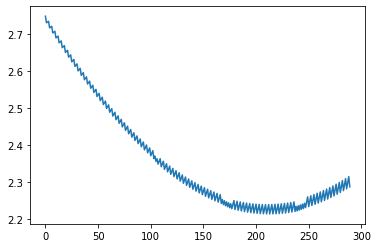

In [7]:
plt.plot(np.log(obj[:,10]))

In [2]:
alpha = 0.05
eta_0 = 1/2
reps = 1 #sort of deprecated. Repetions now occur in parallel, through SLURM
#sim_rep = os.getenv('SLURM_ARRAY_TASK_ID')
sim_rep = 2
np.random.seed(int(sim_rep)) #this sets a different seed for every rep


K_grid = [2]
#global_mean_grid = np.linspace(0.5, 0.7, 10)
global_mean_grid = [0.5]
delta_grid = [0] #maximum spread of the stratum means
sd_grid = [0.05]

results = []
for K, global_mean, delta, sd in itertools.product(K_grid, global_mean_grid, delta_grid, sd_grid):
    shifts = np.linspace(-0.5,0.5,K)
    deltas = shifts * delta
    N = [int(1000/K) for _ in range(K)]
    w = N/np.sum(N)
    etas = construct_vertex_etas(N = N, eta_0 = eta_0)


    x = [random_truncated_gaussian(mean = global_mean + deltas[k], sd = sd, size = N[k]) for k in range(K)]
    #unstratified sample by mixing
    x_unstrat = np.zeros(np.sum(N))
    for i in range(np.sum(N)):
        rand_k =  np.random.choice(np.arange(K), size = 1, p = w)
        x_unstrat[i] = random_truncated_gaussian(mean = global_mean + deltas[rand_k], sd = sd, size = 1)

    unstrat_fixed = mart(x_unstrat, eta = 0.5, lam_func = Bets.fixed, log = True)
    unstrat_agrapa = mart(x_unstrat, eta = 0.5, lam_func = Bets.agrapa, log = True)
    lcb_fixed = global_lower_bound(x, N, Bets.fixed, Allocations.proportional_round_robin, alpha = 0.05, WOR = False, breaks = 1000)
    lcb_agrapa = global_lower_bound(x, N, Bets.agrapa, Allocations.proportional_round_robin, alpha = 0.05, WOR = False, breaks = 1000)
    uinnsm_fixed = union_intersection_mart(x, N, etas, Bets.fixed, Allocations.proportional_round_robin, WOR = False, combine = "product", log = True)[0]
    uinnsm_smooth = negexp_ui_mart(x, N, Allocations.proportional_round_robin, log = True)[0]
    uinnsm_smooth_minimax = negexp_ui_mart(x, N, Allocations.predictable_kelly, log = True)[0]

    stop_unstrat_fixed = np.where(any(unstrat_fixed > -np.log(alpha)), np.argmax(unstrat_fixed > -np.log(alpha)), np.sum(N))
    stop_unstrat_agrapa = np.where(any(unstrat_agrapa > -np.log(alpha)), np.argmax(unstrat_agrapa > -np.log(alpha)), np.sum(N))
    stop_lcb_agrapa = np.where(any(lcb_agrapa > eta_0), np.argmax(lcb_agrapa > eta_0), np.sum(N))
    stop_lcb_fixed = np.where(any(lcb_fixed > eta_0), np.argmax(lcb_fixed > eta_0), np.sum(N))
    stop_uinnsm_fixed = np.where(any(uinnsm_fixed > -np.log(alpha)), np.argmax(uinnsm_fixed > -np.log(alpha)), np.sum(N))
    stop_uinnsm_smooth = np.where(any(uinnsm_smooth > -np.log(alpha)), np.argmax(uinnsm_smooth > -np.log(alpha)), np.sum(N))
    stop_uinnsm_smooth_minimax = np.where(any(uinnsm_smooth_minimax > -np.log(alpha)), np.argmax(uinnsm_smooth_minimax > -np.log(alpha)), np.sum(N))

    results_dict = {
        "K":K,
        "global_mean":global_mean,
        "delta":delta,
        "sd":sd,
        "rep":sim_rep,
        "stop_unstrat_fixed":stop_unstrat_fixed,
        "stop_unstrat_agrapa":stop_unstrat_agrapa,
        "stop_lcb_fixed":stop_lcb_fixed,
        "stop_lcb_agrapa":stop_lcb_agrapa,
        "stop_uinnsm_fixed":stop_uinnsm_fixed,
        "stop_uinnsm_smooth":stop_uinnsm_smooth,
        "stop_uinnsm_smooth_minimax":stop_uinnsm_smooth_minimax
    }
    results.append(results_dict)
results = pd.DataFrame(results)

/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:74: RuntimeWarning: divide by zero encountered in true_divide
  lam_trunc = np.maximum(0, np.minimum(lam_untrunc, c/eta))


In [3]:
ne_smooth = negexp_ui_mart(x, N, Allocations.proportional_round_robin, log = True)
ne_smooth_minimax = negexp_ui_mart(x, N, Allocations.predictable_kelly, log = True)

([<matplotlib.lines.Line2D at 0x7fc453b68be0>],
 [<matplotlib.lines.Line2D at 0x7fc453bcc190>])

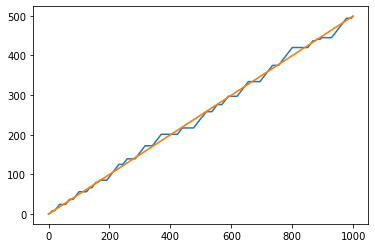

In [4]:
plt.plot(ne_smooth_minimax[2][:,1]), plt.plot(ne_smooth[2][:,1])

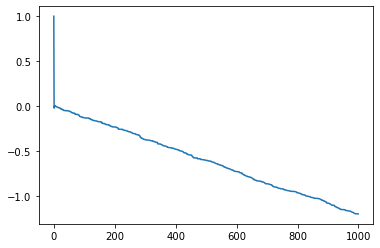

In [5]:
plt.plot(uinnsm_smooth_minimax)

In [66]:
max_iterations = 1000

allocation_func = Allocations.predictable_kelly
#allocation_func = Allocations.proportional_round_robin

log = True
w = N / np.sum(N) #stratum weights
K = len(N) #number of strata
n = [x[k].shape[0] for k in range(K)]    
global_mean = 0.5
deltas = [-0.4,0.4]
#x = [random_truncated_gaussian(mean = global_mean + deltas[k], sd = sd, size = N[k]) for k in range(K)]

#define constraint set for pypoman projection
A = np.concatenate((
    np.expand_dims(w, axis = 0),
    np.expand_dims(-w, axis = 0),
    -np.identity(K),
    np.identity(K)))
b = np.concatenate((eta_0 * np.ones(2), np.zeros(K), np.ones(K)))
proj = lambda eta: pypoman.projection.project_point_to_polytope(point = eta, ineq = (A, b))
delta = 0.5 #dampening parameter

#this is a nested list of arrays
#it stores the samples available in each stratum at time i = 0,1,2,...,n
samples_t = [[[] for _ in range(K)] for _ in range(np.sum(n))]
#initialize with no samples
uinnsms = [0] if log else 1 #uinnsm starts at 1 at time 0
samples_t[0] = [np.array([]) for _ in range(K)] #initialize with no samples
T_k = np.zeros((np.sum(n), K), dtype = int)
eta_stars = np.zeros((np.sum(n), K))

for i in np.arange(1, 300-1):
    #select next stratum
    S_i = allocation_func(x, T_k[i-1,:], n, N, eta = eta_stars[i-1], lam_func = Bets.smooth_predictable)
    T_k[i,:] = T_k[i-1,:]
    T_k[i,S_i] += 1
    for k in np.arange(K):
        samples_t[i][k] = x[k][np.arange(T_k[i,k])] #update available samples
    #initial estimate of minimum by projecting current sample mean onto null space
    if any(T_k[i,:] == 0):
        sample_means = np.array([eta_0 for _ in range(K)])
    else:
        sample_means = np.array([np.mean(samples_t[i][k]) for k in range(K)])
    #eta_l = proj(sample_means)
    eta_l = np.array([0.5,0.5])
    #eta_l = np.array([0.1,0.9])
    step_size = 1
    counter = 0
    etas = eta_l
    objs = 0
    #find optimum
    #while step_size > 1e-5:
    while np.linalg.norm(grad_l) > 0.001:
        counter += 1
        if counter == max_iterations:
            raise Exception("Gradient descent took too many steps to converge. Raise max_iterations, or check conditioning of the optimization problem.")
        grad_l = PGD.grad(samples_t[i], eta_l)
        hess_l = PGD.hessian(samples_t[i], eta_l)
        #take dampened Newton step and then project onto null
        next_eta = proj(eta_l - (delta/hess_l) * grad_l)
        step_size = PGD.global_log_mart(samples_t[i], eta_l) - PGD.global_log_mart(samples_t[i], next_eta)
        eta_l = next_eta
        etas = np.vstack([etas, eta_l])
        objs = np.vstack([objs, PGD.global_log_mart(samples_t[i], next_eta)])
#         if counter > 50: 
#             break 
#     if counter > 50:
#         break
    eta_stars[i] = eta_l
    #store current value of UI-TS
    log_ts = PGD.global_log_mart(samples_t[i], eta_stars[i])
    if log:
        uinnsms.append(log_ts)
    else:
        uinnsms.append(np.exp(log_ts))

Exception: Gradient descent took too many steps to converge. Raise max_iterations, or check conditioning of the optimization problem.

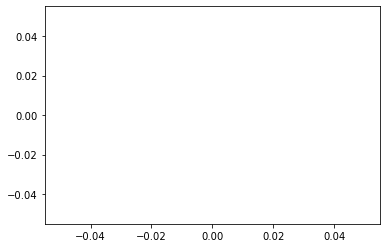

In [67]:
#plot uinnsms over sampling time
plt.plot(uinnsms)

In [68]:
eta_l - (1/hess_l) * grad_l

array([1.28475349e+00, 1.11022302e-16])

In [63]:
#it seems like the problem is that the optimization can become very poorly conditioned 
#in particular if the sample sizes are highly imbalanced, or if 
proj(eta_l - (delta/hess_l) * grad_l)

array([1.00000000e+00, 1.11022302e-16])

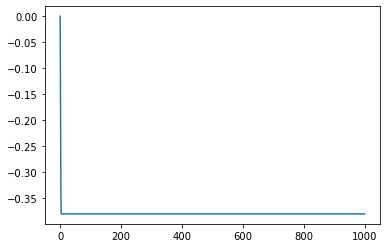

In [64]:
#plot objective over PGD steps
plt.plot(objs)

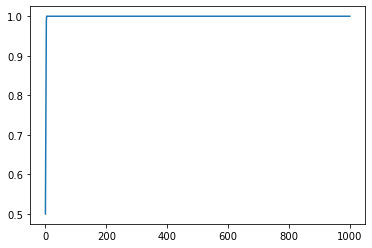

In [65]:
#plot eta over PGD steps
plt.plot(etas[:,0])

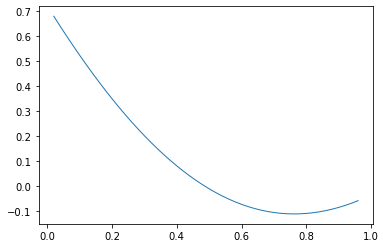

In [49]:
plot_marts_eta(x = samples_t[3],
               N = N, 
               lam_func = Bets.smooth_predictable, 
               allocation_func = Allocations.predictable_kelly,
               combine = "product",
               res = 2e-2)